In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
import os
import sys
import warnings
import numpy
import ccxt
import pandas as pd
import numpy as np
from time import time
import math
import cProfile as cp

from gym.spaces import Space, Box

config = './neat.config'

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.abspath('')+"\\tensortrade")


In [3]:
!pip install ..\forks\tensortrade_source -U


Processing c:\users\codeninja\dev\forks\tensortrade_source
  Created wheel for tensortrade: filename=tensortrade-0.0.2rc0-cp37-none-any.whl size=55835 sha256=dff5956e531a179c6f711d54ff23d3833bf08ee7669074051a44bd2006f60dd1
  Stored in directory: C:\Users\CODENI~1\AppData\Local\Temp\pip-ephem-wheel-cache-zfm41l3t\wheels\62\be\3a\90782c795f0ba93fec4a55c551ac7e8f7e7ea933797e4f71c0
Successfully built tensortrade
  Found existing installation: tensortrade 0.0.2rc0
    Uninstalling tensortrade-0.0.2rc0:
      Successfully uninstalled tensortrade-0.0.2rc0


**Import dataframe**

In [18]:

data_file ='./data/processed/binance/btc_usdt_1h.csv' 
df = pd.read_csv(data_file, index_col=[0])


# number of days we want to pull from the dataframe 
days_of_data = 365

# number of data frames (our DF is in 1h timesteps)
frames = days_of_data * 24 * 5
# frames = len(df)
train_test_percentage = 0.4

x_train = int(frames * (1 - train_test_percentage))
x_test = int(frames - x_train)

df_train = df[-frames:(-x_test - 1)]
df_test = df[-x_test:]
print("Friend Shape", df.shape)
print('train shape', df_train.shape)
print('test shape', df_test.shape)
print('columns', df.columns)

Friend Shape (180236, 12)
train shape (26279, 12)
test shape (17520, 12)
columns Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


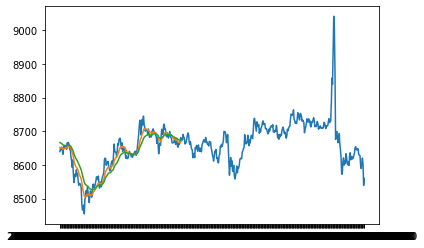

In [19]:
import matplotlib.pyplot as plt

# plt.subplot(221)
plt.plot(df_train[:500]['close'])
plt.plot(df_train[:200]['trend_ema_fast'])
plt.plot(df_train[:200]['trend_ema_slow'])

# plt.subplot(222)
# plt.plot(df_test[:200]['close'])
# plt.plot(df_test[:200]['trend_ema_fast'])
# plt.plot(df_test[:200]['trend_ema_slow'])

plt.show()

In [27]:
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
from neat_reward_strategy import NeatRewardStrategy as ProfitStrategy
from tensortrade.actions import DiscreteActionStrategy as ActionStrategy
from tensortrade.exchanges.simulated import SimulatedExchange as Exchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline
from tensortrade.environments import TradingEnvironment as Environment

print('fin imports')
normalize = MinMaxNormalizer(inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize])

reward_strategy = ProfitStrategy()
action_strategy = ActionStrategy(n_actions=20, instrument_symbol='BTC/USDT')
print('fin strats')

exchange = Exchange(data_frame=df_train,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.75,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_train.columns
                   )
print('fin exchange')

environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)
print('fin environment')

strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=True,
                           only_show_profitable=True,
                           learn_to_trade_theshold=-10000,
                           data_frame_window = 2000
                          )

print("Running through ", exchange.data_frame.shape[0], ' steps')
# cp.run("performance, winner, stats = strategy.run(generations=20)", 'evolution_stats')
performance, winner, stats = strategy.run(generations=20)

fin imports
fin strats
fin exchange
fin environment
Running through  26279  steps

 ****** Running generation 0 ****** 

---------------------------
---------------------------


KeyboardInterrupt: 

5.0

In [ ]:
# import numpy as np
# low = np.array([exchange._min_trade_price, ] * (len(exchange._observation_columns)-1) + [exchange._min_trade_amount, ])
# high = np.array([exchange._max_trade_price, ] * (len(exchange._observation_columns)-1) + [exchange._max_trade_amount, ])
# b = Box(low=low, high=high, dtype='float')
# print(b, len(exchange.data_frame.columns), exchange.generated_space)
# print(exchange._feature_pipeline.steps)

# from tensortrade.features.scalers import MinMaxNormalizer

# exchange._feature_pipeline.transform_space(exchange._data_frame, b)
# normalize = MinMaxNormalizer(columns=['open','close','high','low','volume'], inplace=True)
# normalize.transform(exchange.data_frame,b)

In [16]:
import pstats
from pstats import SortKey
p = pstats.Stats('evolution_stats')
p.strip_dirs().sort_stats("cumtime").print_stats(20)

Wed Oct 30 23:48:51 2019    evolution_stats

         1488770 function calls (1456329 primitive calls) in 1.139 seconds

   Ordered by: cumulative time
   List reduced from 742 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.139    1.139 {built-in method builtins.exec}
        1    0.000    0.000    1.139    1.139 <string>:1(<module>)
        1    0.000    0.000    1.139    1.139 neat_trading_strategy.py:261(run)
        1    0.000    0.000    1.139    1.139 population.py:59(run)
        1    0.000    0.000    1.138    1.138 neat_trading_strategy.py:182(_eval_population)
        4    0.009    0.002    1.109    0.277 neat_trading_strategy.py:203(eval_genome)
      604    0.002    0.000    0.812    0.001 trading_environment.py:177(step)
     3029    0.007    0.000    0.534    0.000 indexing.py:1396(__getitem__)
     3029    0.010    0.000    0.525    0.000 indexing.py:2110(_getitem_axis)
     2421    

**Evaluate**

In [9]:
exchange = Exchange(data_frame=df,
                    should_pretransform_obs = True,
                    base_instrument='USDT', 
                    timeframe='1h',
                    dtype=np.float32,
                    commission_percent=0.5,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4
                   )
environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

environment.reset()
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy

strategy = TradingStrategy(environment=environment, watch_genome_evaluation=True, full_evaluation = True, neat_config=config)

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
strategy.eval_genome(winner)

In [ ]:
print(environment.exchange.trades)
environment.exchange.performance.net_worth.plot()

**Save Strategy**

In [ ]:
columns = ["Action"]+list(exchange.data_frame.columns)

nodes = list(range(len(columns)*-1,1))
nodes.reverse()
node_names = dict( zip(nodes, columns))
print(node_names)

In [ ]:
import visualize

visualize.plot_stats(stats, ylog=False, view=True)


In [ ]:
visualize.plot_species(stats, view=True)

In [ ]:
visualize.draw_net(strategy._config, winner, False, node_names=node_names)


In [ ]:
dir(winner.connections.keys)
keys = list(winner.connections.values())

keys[0].weight/5

In [ ]:
from tensortrade.trades import Trade, TradeType


In [ ]:
print(TradeType( % len(TradeType)))
exchange.execute_trade(action_strategy.get_trade(5))
exchange.trades

In [ ]:
int(20*0.1244)